In [587]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import warnings
warnings.filterwarnings("ignore")


In [588]:
# Ans a. Load the dataset 
df = pd.read_csv('datasets/liver_disease.csv')
df.head()


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,Yes
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,Yes
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,Yes
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,Yes
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,Yes


In [589]:
# Ans b. Below few steps will analyze and cleanse the data
# Find missing (Null) fields in the dataset
df.isnull().sum()


Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [590]:
# From above we see: Albumin_and_Globulin_Ratio has 4 Null values. Replace these with Median
df.Albumin_and_Globulin_Ratio.fillna(df['Albumin_and_Globulin_Ratio'].mean(), inplace=True )


Number of patients diagnosed with liver disease:  416
Number of patients not diagnosed with liver disease:  167


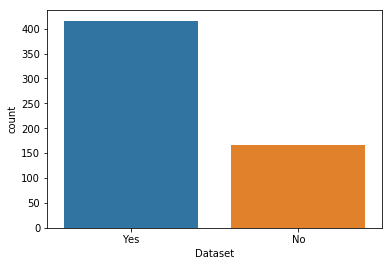

In [591]:
sns.countplot(data = df, x = 'Dataset', label='Count')

liverDisease_yes, liverDisease_no = df['Dataset'].value_counts()
print('Number of patients diagnosed with liver disease: ',liverDisease_yes)
print('Number of patients not diagnosed with liver disease: ',liverDisease_no)

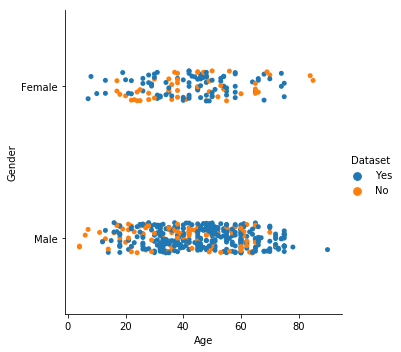

In [592]:
sns.catplot(x="Age", y="Gender", hue="Dataset", data=df)

Observation: There seems to be a higher concentration around 40 - 60 range

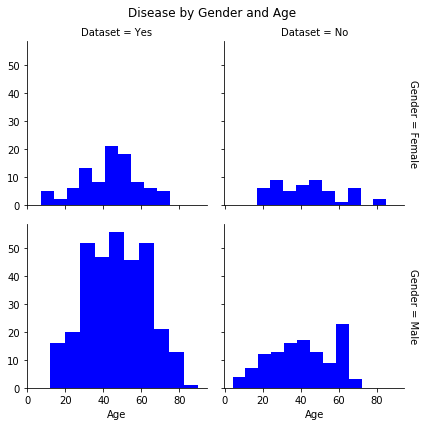

In [593]:
# Further evaluating the impact of Age on the outcome
g = sns.FacetGrid(df, col="Dataset", row="Gender", margin_titles=True)
g.map(plt.hist, "Age", color="blue")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Disease by Gender and Age');


Observation: Looking at the above plot, we can consider Age to be a relevant factor for liver disease evaluation

In [594]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    583 non-null float64
Dataset                       583 non-null object
dtypes: float64(5), int64(4), object(2)
memory usage: 50.2+ KB


Observation: Except Gender & Dataset, other attributes are numeric. We can convert these from Categorical to Indicator

In [595]:
# Binarize the Gender & Dataset columns
label_encoder = LabelEncoder()

label_encoder.fit(df.Gender.unique())
df['Gender_Encoded'] = label_encoder.transform(df.Gender)

label_encoder.fit(df.Dataset.unique())
df['Dataset_Encoded'] = label_encoder.transform(df.Dataset)

# df.head()


In [596]:
# With the binary encoded Gender & Dataset available, we no longer need the original columns
X = df.drop(['Gender'], axis=1)
X.drop(['Dataset', 'Dataset_Encoded'], axis = 1, inplace = True)
y = df['Dataset_Encoded']


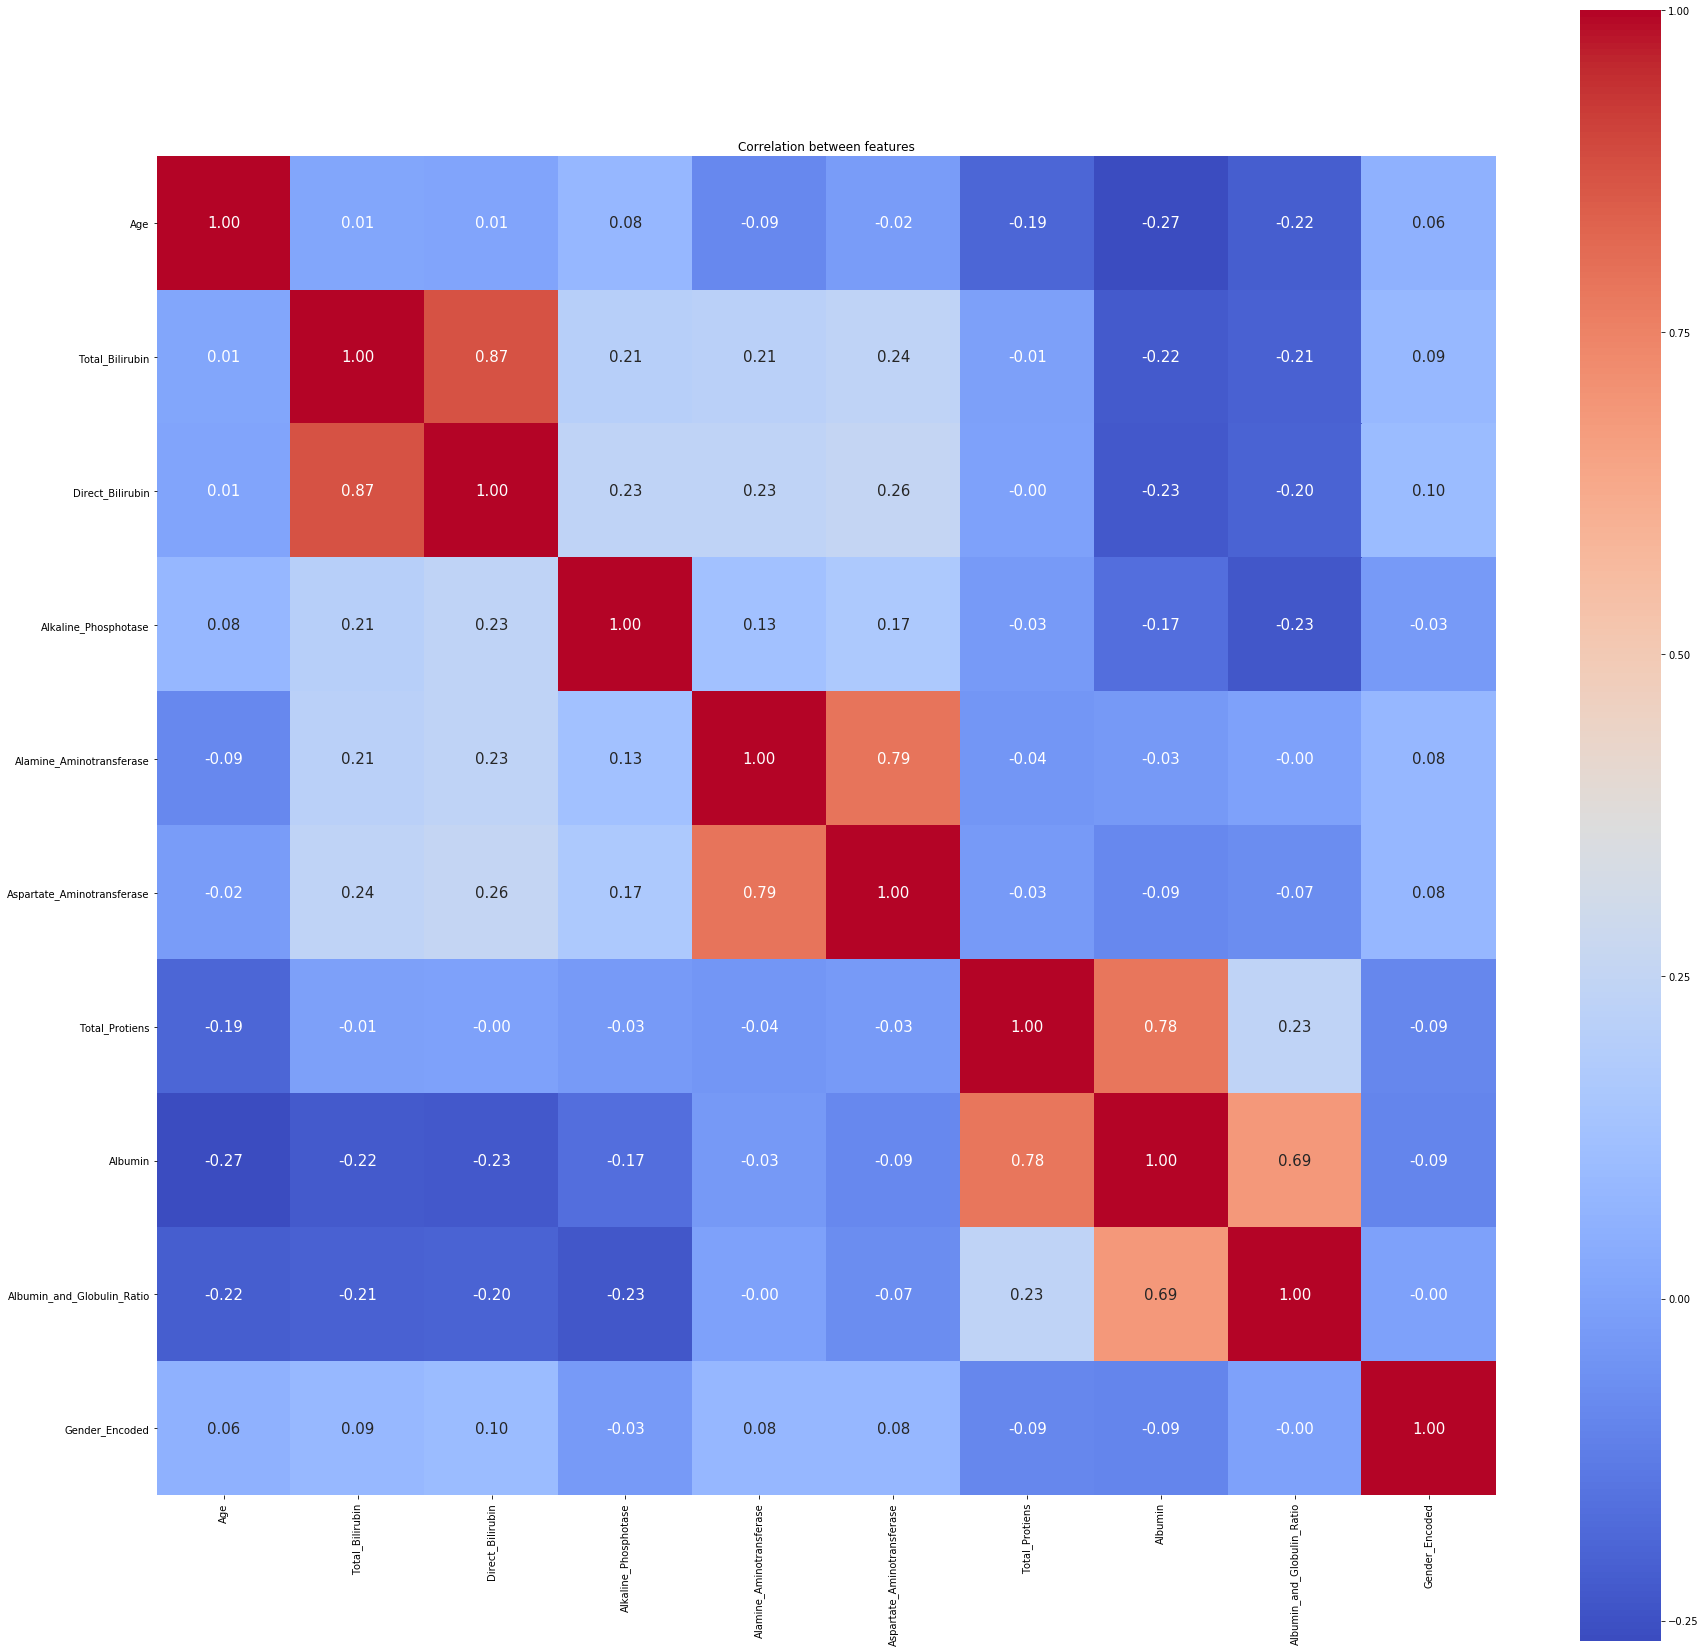

In [597]:
# Lets evaluate correlation amongst attributes
liverDisease_corr = X.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(liverDisease_corr, cbar=True, square=True, annot= True, fmt= '.2f',annot_kws={'size': 15}, cmap='coolwarm')
plt.title('Correlation between features');


Observation: The above heatmap indicates the following correlation:
1. Direct_Bilirubin & Total_Bilirubin;
2. Alamine_Aminotransferase & Aspartate_Aminotransferase;
3. Total_Protiens & Albumin;

There is some correlation between Albumin_and_Globulin_Ratio and Albumin. But its not as high.

We have the possibility of removing one amongst the strongly correlated features

We will DROP the follwing features: 
1. Direct_Bilirubin
2. Aspartate_Aminotransferase 
3. Albumin

In [598]:
# Ans c. Based on above observations, drop some of the strongly correlated features
X.drop(['Direct_Bilirubin', 'Aspartate_Aminotransferase', 'Albumin'], axis = 1, inplace = True)
X.head()


,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Total_Protiens,Albumin_and_Globulin_Ratio,Gender_Encoded
0,65,0.7,187,16,6.8,0.90,0
1,62,10.9,699,64,7.5,0.74,1
2,62,7.3,490,60,7.0,0.89,1
3,58,1.0,182,14,6.8,1.00,1
4,72,3.9,195,27,7.3,0.40,1


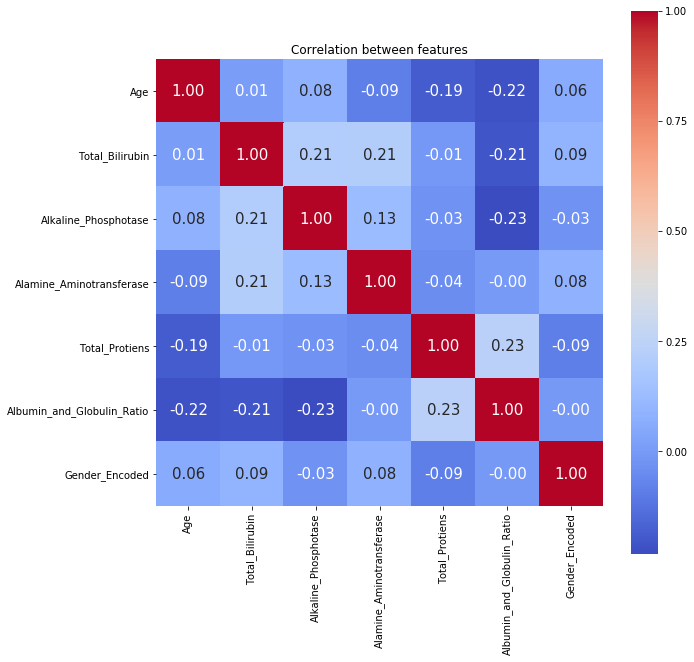

In [599]:
liverDisease_corr = X.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(liverDisease_corr, cbar=True, square=True, annot=True, fmt= '.2f',annot_kws={'size': 15}, cmap='coolwarm')
plt.title('Correlation between features');


In [600]:
# And d. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [601]:
# Ans e. Implement Logistic Regression Classifier
# Method 1: Direct appliction of Logistic Regression

# Fit model & predict outcome using Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_predicted = logreg.predict(X_test)
y_predicted_proba = logreg.predict_proba(X_test)[:, 1]

# Ans f. Calculate accuracy measures 
print('Coefficient: \n', logreg.coef_)

print('Intercept: ', logreg.intercept_)

print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, y_predicted) * 100))

print('AUC: {:.2f}%'.format(roc_auc_score(y_test, y_predicted_proba) * 100))

print('Classification report: \n\n', classification_report(y_test, y_predicted))

print('Confusion Matrix: \n', confusion_matrix(y_test,y_predicted))

print('\nTraining set score: {:.2f}%'.format(logreg.score(X_train, y_train) * 100))

print('Testing set score: {:.2f}%'.format(logreg.score(X_test, y_test) * 100))


Coefficient: 
 [[ 0.0218891   0.17723536  0.00097348  0.01352304  0.04849036 -0.52684422
   0.01766849]]
Intercept:  [-1.05030511]
Accuracy: 72.57%
AUC: 77.62%
Classification report: 

               precision    recall  f1-score   support

           0       0.57      0.16      0.25        50
           1       0.74      0.95      0.83       125

   micro avg       0.73      0.73      0.73       175
   macro avg       0.66      0.56      0.54       175
weighted avg       0.69      0.73      0.67       175

Confusion Matrix: 
 [[  8  42]
 [  6 119]]

Training set score: 73.04%
Testing set score: 72.57%


In [602]:
# Ans g. Fine tune the model using different regularization parameters
# Method 2: Logistic Regression with Cross Validation
strat_k_fold = StratifiedKFold(n_splits=10, shuffle=False)

c_values = list(np.arange(1,100))
param_grid = [
    {
        'C': c_values,
        'penalty': ['l1'],
        'solver': ['liblinear'],
        'multi_class': ['ovr'],
        'random_state': [42]
    },
    {
        'C': c_values,
        'penalty': ['l2'],
        'solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'multi_class': ['ovr'],
        'random_state': [42]
    }
]

grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=strat_k_fold,
    scoring='f1'
)

grid.fit(X,y)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73...'l2'], 'solver': ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class': ['ovr'], 'random_state': [42]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [603]:
# Best Logistic Regression Parameters
print(grid.best_params_)
# Best score for Logistic Regression with best parameters
print('Best score: {:.2f}%'.format(grid.best_score_ * 100))


{'C': 15, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
Best score: 83.41%


In [604]:
logreg = LogisticRegression(
    # Parameter choosen based on GridSearchCV result
    C=15,
    multi_class='ovr',
    penalty='l2',
    solver='lbfgs',
    random_state=42
)
logreg.fit(X_train, y_train)

y_predicted = logreg.predict(X_test)
y_predicted_proba = logreg.predict_proba(X_test)[:, 1]

print('Coefficient: \n', logreg.coef_)

print('Intercept: ', logreg.intercept_)

print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, y_predicted) * 100))

print('AUC: {:.2f}%'.format(roc_auc_score(y_test, y_predicted_proba) * 100))

print('Classification report: \n\n', classification_report(y_test, y_predicted))

print('Confusion Matrix: \n', confusion_matrix(y_test,y_predicted))

print('\nTraining set score: {:.2f}%'.format(logreg.score(X_train, y_train) * 100))

print('Testing set score: {:.2f}%'.format(logreg.score(X_test, y_test) * 100))

Coefficient: 
 [[ 2.06579329e-02  1.67092583e-01  8.23341498e-04  1.33630919e-02
   8.26937829e-02 -9.10069346e-01  1.23714585e-01]]
Intercept:  [-0.86215651]
Accuracy: 73.71%
AUC: 77.60%
Classification report: 

               precision    recall  f1-score   support

           0       0.61      0.22      0.32        50
           1       0.75      0.94      0.84       125

   micro avg       0.74      0.74      0.74       175
   macro avg       0.68      0.58      0.58       175
weighted avg       0.71      0.74      0.69       175

Confusion Matrix: 
 [[ 11  39]
 [  7 118]]

Training set score: 73.04%
Testing set score: 73.71%


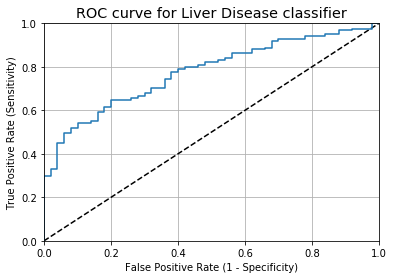

In [605]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Liver Disease classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)